# 🔥 GRU Model Training: Emotion Classification

This notebook trains a GRU (Gated Recurrent Unit) model on preprocessed emotion data using **Word2Vec** pre-trained embeddings.

**Embedding Strategy:** Word2Vec (Google News, 300d) - captures local context patterns that complement GRU's fast sequential processing.


## 📚 Import Libraries


In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')


2025-11-23 20:25:40.105372: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-23 20:25:40.148331: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-23 20:25:41.346335: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## 📂 Load Preprocessed Data


In [3]:
# Load preprocessed training and validation data
train_df = pd.read_pickle('./data/train_preprocessed.pkl')
val_df = pd.read_pickle('./data/validation_preprocessed.pkl')

print(f"Training data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(train_df.head())


Training data shape: (15999, 2)
Validation data shape: (2000, 2)

Columns: ['Text', 'Label']

First few rows:
                                                Text  Label
0                              didnt feel humiliated      0
1  go feeling hopeless damned hopeful around some...      0
2          im grabbing minute post feel greedy wrong      3
3  ever feeling nostalgic fireplace know still pr...      2
4                                    feeling grouchy      3


In [4]:
train_df.head(10)

,Text,Label
0,didnt feel humiliated,0
1,go feeling hopeless damned hopeful around some...,0
2,im grabbing minute post feel greedy wrong,3
3,ever feeling nostalgic fireplace know still pr...,2
4,feeling grouchy,3
5,ive feeling little burdened lately wasnt sure,0
6,ive taking milligrams times recommended amount...,5
7,feel confused life teenager jaded year old man,4
8,petronas years feel petronas performed well ma...,1
9,feel romantic,2


## 📊 Prepare Data

Split the data into features (X) and labels (y).


In [5]:
#  Prepare X and y
X_train = train_df['Text']
y_train = train_df['Label']
X_val = val_df['Text']
y_val = val_df['Label']

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"\nLabel distribution in training set:")
print(y_train.value_counts().sort_index())


Training samples: 15999
Validation samples: 2000

Label distribution in training set:
Label
0    4666
1    5361
2    1304
3    2159
4    1937
5     572
Name: count, dtype: int64


## 🔠 Tokenization

Convert text to sequences of integers.


In [6]:
# Initialize tokenizer
tokenizer = Tokenizer(num_words=60000)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

# Find maximum sequence length
maxlen = max(len(tokens) for tokens in X_train_sequences)
print(f"Maximum sequence length: {maxlen}")

# Pad sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=maxlen, padding='post')

print(f"\nX_train_padded shape: {X_train_padded.shape}")
print(f"X_val_padded shape: {X_val_padded.shape}")

# Calculate input size for embedding layer
input_size = np.max(X_train_padded) + 1
print(f"Vocabulary size (input_size): {input_size}")


Maximum sequence length: 35

X_train_padded shape: (15999, 35)
X_val_padded shape: (2000, 35)
Vocabulary size (input_size): 15064


## 🔤 Prepare Word2Vec Embeddings

Using pre-trained **Word2Vec** embeddings for the GRU model. Word2Vec captures local context patterns, which complements GRU's fast sequential processing.


In [7]:
# Download and prepare Word2Vec embeddings
import gensim.downloader as api

print("📥 Downloading Word2Vec pre-trained embeddings (Google News 300d)...")
print("This may take a few minutes on first run...")

# Download pre-trained Word2Vec model (Google News, 300 dimensions)
word2vec_model = api.load('word2vec-google-news-300')

print("✅ Word2Vec embeddings loaded successfully!")

# Embedding dimension
embedding_dim = 300

# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill embedding matrix with Word2Vec vectors
hits = 0
misses = 0

for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = word2vec_model[word]
        embedding_matrix[i] = embedding_vector
        hits += 1
    except KeyError:
        # Word not in Word2Vec vocabulary, leave as zeros
        misses += 1

print(f"\n📊 Embedding Matrix Statistics:")
print(f"   Vocabulary size: {vocab_size}")
print(f"   Embedding dimension: {embedding_dim}")
print(f"   Words found in Word2Vec: {hits}")
print(f"   Words not found (using zeros): {misses}")
print(f"   Coverage: {100 * hits / (hits + misses):.2f}%")


📥 Downloading Word2Vec pre-trained embeddings (Google News 300d)...
This may take a few minutes on first run...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
✅ Word2Vec embeddings loaded successfully!

📊 Embedding Matrix Statistics:
   Vocabulary size: 15064
   Embedding dimension: 300
   Words found in Word2Vec: 13702
   Words not found (using zeros): 1361
   Coverage: 90.96%


## 🛠️ Build GRU Model

**Model Architecture:**
1. **Embedding Layer**: Pre-trained **Word2Vec** embeddings (300d, frozen)
   - Captures local context and word associations
   - Google News corpus (3 billion words)
2. **Bidirectional GRU**: Processes sequences in both directions
3. **Batch Normalization**: Normalizes activations for stable training
4. **Dropout**: Prevents overfitting (50% dropout rate)
5. **Dense Layer**: Fully connected layer with ReLU activation
6. **Output Layer**: 6 units with softmax for emotion classification


In [9]:
# Define the GRU model with Word2Vec embeddings
model = Sequential()

# Embedding layer with pre-trained Word2Vec weights
# trainable=False keeps the embeddings frozen (transfer learning)
# Set trainable=True if you want to fine-tune embeddings during training
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=maxlen,
    trainable=False  # Keep Word2Vec embeddings frozen
))

# Bidirectional GRU layer with 128 units
model.add(Bidirectional(GRU(128)))

# Batch normalization
model.add(BatchNormalization())

# Dropout for regularization
model.add(Dropout(0.5))

# Dense layer with ReLU activation
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer with 6 units (6 emotions) and softmax activation
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\n🎯 Model using Word2Vec pre-trained embeddings (300d, frozen)")

# Display model summary
model.summary()



🎯 Model using Word2Vec pre-trained embeddings (300d, frozen)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     4,519,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,519,200 (17.24 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,519,200 (17.24 MB)

## 🚀 Train the Model

Train with early stopping to prevent overfitting.


In [10]:
# Train the model
history = model.fit(
    X_train_padded, y_train,
    epochs=2,
    batch_size=32,
    validation_data=(X_val_padded, y_val),
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)


Epoch 1/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5388 - loss: 1.3134 - val_accuracy: 0.7335 - val_loss: 0.8504
Epoch 2/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7540 - loss: 0.7015 - val_accuracy: 0.8745 - val_loss: 0.3770


## 📊 Visualize Training Progress


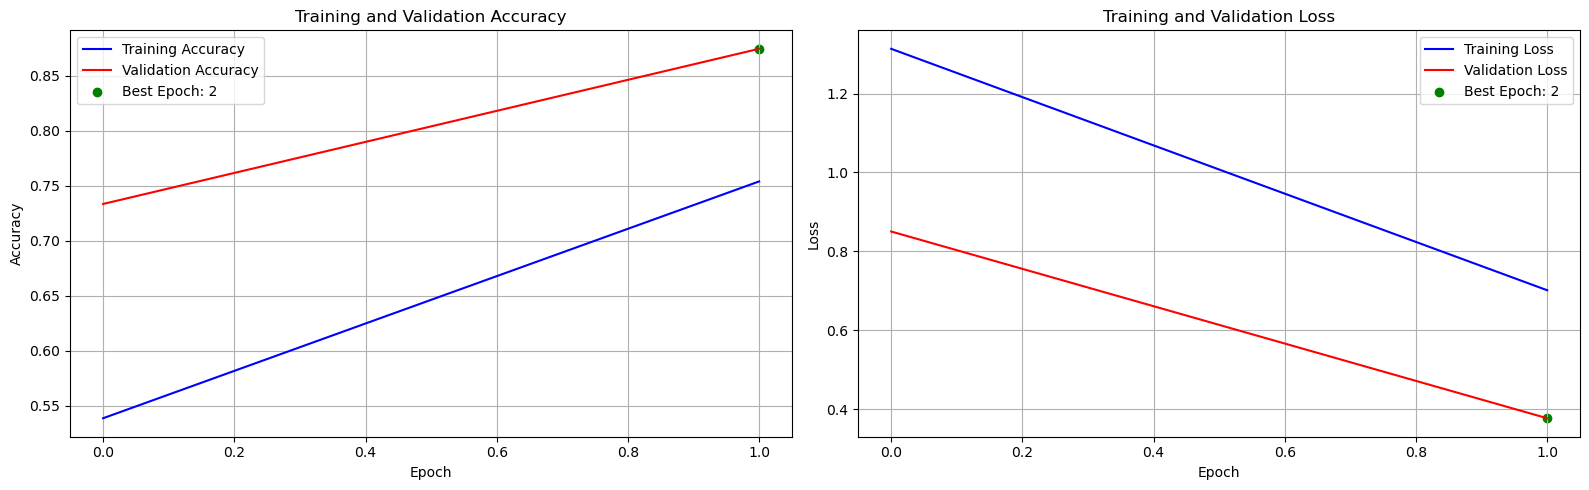

In [11]:
# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], 
               color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()
axs[0].grid(True)

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], 
               color='green', label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


## 📈 Evaluate Model Performance


In [12]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val_padded, y_val)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8745 - loss: 0.3770

Validation Loss: 0.3770
Validation Accuracy: 0.8745


## 🎯 Confusion Matrix


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


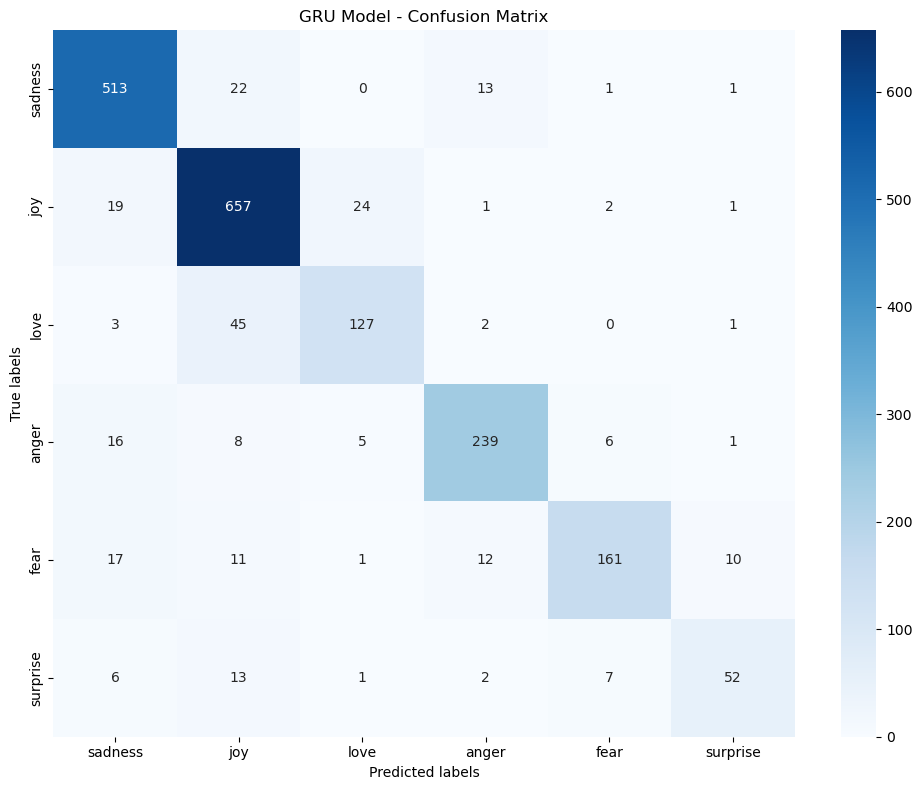

In [13]:
# Get predictions
y_val_pred = model.predict(X_val_padded)
y_val_pred = np.argmax(y_val_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'],
            yticklabels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('GRU Model - Confusion Matrix')
plt.tight_layout()
plt.show()


## 📝 Classification Report


In [15]:
# Print classification report
emotion_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=emotion_names))



Classification Report:
              precision    recall  f1-score   support

     sadness       0.89      0.93      0.91       550
         joy       0.87      0.93      0.90       704
        love       0.80      0.71      0.76       178
       anger       0.89      0.87      0.88       275
        fear       0.91      0.76      0.83       212
    surprise       0.79      0.64      0.71        81

    accuracy                           0.87      2000
   macro avg       0.86      0.81      0.83      2000
weighted avg       0.87      0.87      0.87      2000



## 🔬 Hyperparameter Tuning Experiments

Now let's systematically test different hyperparameters to understand their impact on model performance.


In [17]:
# Function to create and train a GRU model with custom hyperparameters
def train_gru_model(gru_units=128, dropout_rate=0.5, learning_rate=0.001, 
                     batch_size=32, dense_units=64, epochs=2, 
                     embedding_trainable=False, optimizer_name='adam'):
    """
    Train a GRU model with specified hyperparameters and return validation results.
    """
    # Build model
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=embedding_trainable
    ))
    model.add(Bidirectional(GRU(gru_units)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(6, activation='softmax'))
    
    # Compile with specified optimizer and learning rate
    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        optimizer = 'adam'
    
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # Train
    history = model.fit(
        X_train_padded, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_padded, y_val),
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
        verbose=0  # Suppress output for cleaner results
    )
    
    # Evaluate on validation set
    val_loss, val_accuracy = model.evaluate(X_val_padded, y_val, verbose=0)
    
    return {
        'val_accuracy': val_accuracy,
        'val_loss': val_loss,
        'best_epoch': len(history.history['val_accuracy']),
        'history': history.history
    }

print("✅ Helper function defined")


✅ Helper function defined


### 🔍 Experiment 1: Learning Rate

Test different learning rates to find the optimal value.


Testing different learning rates...
Testing learning rate: 0.0001
  Val Accuracy: 0.7860, Val Loss: 0.6306

Testing learning rate: 0.0005
  Val Accuracy: 0.9255, Val Loss: 0.1899

Testing learning rate: 0.001
  Val Accuracy: 0.9265, Val Loss: 0.1627

Testing learning rate: 0.005
  Val Accuracy: 0.9260, Val Loss: 0.2232

Testing learning rate: 0.01
  Val Accuracy: 0.9115, Val Loss: 0.2104


📊 Learning Rate Results:
 learning_rate  val_accuracy  val_loss  epochs
        0.0001        0.7860  0.630647      10
        0.0005        0.9255  0.189886      10
        0.0010        0.9265  0.162723      10
        0.0050        0.9260  0.223197       9
        0.0100        0.9115  0.210382      10


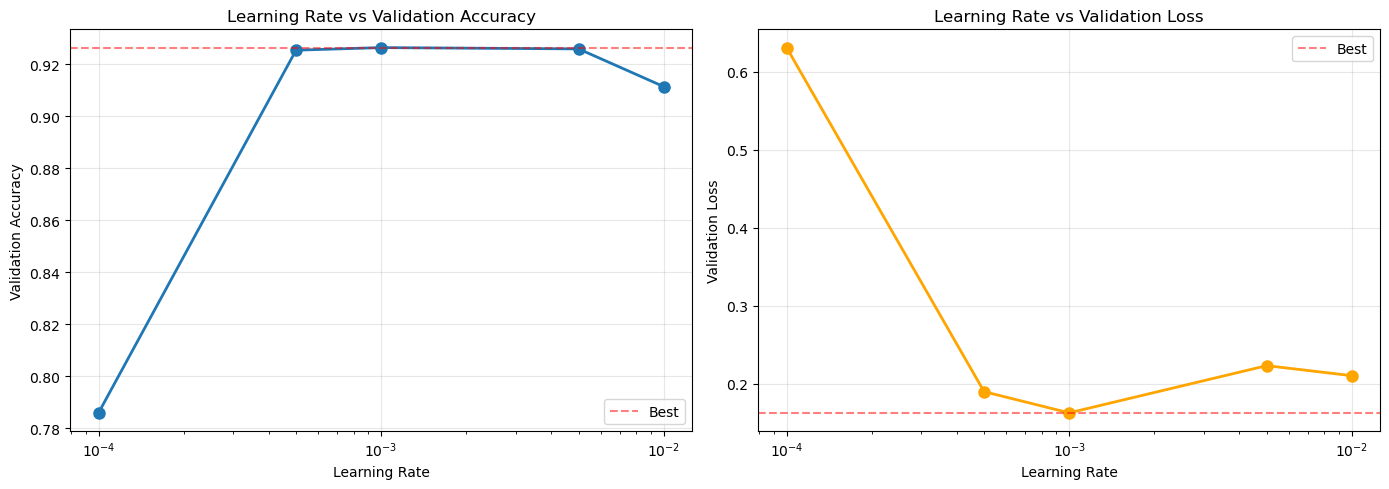


✅ Best Learning Rate: 0.001 with accuracy 0.9265


In [18]:
# Test different learning rates
import tensorflow as tf

learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
lr_results = []

print("Testing different learning rates...")
print("=" * 60)

for lr in learning_rates:
    print(f"Testing learning rate: {lr}")
    result = train_gru_model(learning_rate=lr, epochs=10)
    lr_results.append({
        'learning_rate': lr,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss'],
        'epochs': result['best_epoch']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}, Val Loss: {result['val_loss']:.4f}\n")

# Convert to DataFrame for visualization
lr_df = pd.DataFrame(lr_results)
print("\n📊 Learning Rate Results:")
print(lr_df.to_string(index=False))

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(lr_df['learning_rate'], lr_df['val_accuracy'], 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Learning Rate vs Validation Accuracy')
axes[0].set_xscale('log')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=lr_df['val_accuracy'].max(), color='r', linestyle='--', alpha=0.5, label='Best')
axes[0].legend()

# Loss plot
axes[1].plot(lr_df['learning_rate'], lr_df['val_loss'], 'o-', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Learning Rate vs Validation Loss')
axes[1].set_xscale('log')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=lr_df['val_loss'].min(), color='r', linestyle='--', alpha=0.5, label='Best')
axes[1].legend()

plt.tight_layout()
plt.show()

best_lr = lr_df.loc[lr_df['val_accuracy'].idxmax(), 'learning_rate']
print(f"\n✅ Best Learning Rate: {best_lr} with accuracy {lr_df['val_accuracy'].max():.4f}")


### 🔍 Experiment 2: Batch Size

Test different batch sizes to find the optimal value.


In [ ]:
# Test different batch sizes
batch_sizes = [16, 32, 64, 128]
batch_results = []

print("Testing different batch sizes...")
print("=" * 60)

for bs in batch_sizes:
    print(f"Testing batch size: {bs}")
    result = train_gru_model(batch_size=bs, epochs=10)
    batch_results.append({
        'batch_size': bs,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss'],
        'epochs': result['best_epoch']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}, Val Loss: {result['val_loss']:.4f}\n")

# Convert to DataFrame
batch_df = pd.DataFrame(batch_results)
print("\n📊 Batch Size Results:")
print(batch_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(batch_df['batch_size'], batch_df['val_accuracy'], 'o-', linewidth=2, markersize=8, color='green')
axes[0].set_xlabel('Batch Size')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Batch Size vs Validation Accuracy')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=batch_df['val_accuracy'].max(), color='r', linestyle='--', alpha=0.5)

axes[1].plot(batch_df['batch_size'], batch_df['val_loss'], 'o-', linewidth=2, markersize=8, color='red')
axes[1].set_xlabel('Batch Size')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Batch Size vs Validation Loss')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=batch_df['val_loss'].min(), color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

best_batch = batch_df.loc[batch_df['val_accuracy'].idxmax(), 'batch_size']
print(f"\n✅ Best Batch Size: {best_batch} with accuracy {batch_df['val_accuracy'].max():.4f}")


### 🔍 Experiment 3: GRU Units

Test different numbers of GRU units to find optimal model capacity.


In [ ]:
# Test different numbers of GRU units
gru_units_list = [64, 96, 128, 192, 256]
gru_results = []

print("Testing different GRU unit counts...")
print("=" * 60)

for units in gru_units_list:
    print(f"Testing GRU units: {units}")
    result = train_gru_model(gru_units=units, epochs=10)
    gru_results.append({
        'gru_units': units,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss'],
        'epochs': result['best_epoch']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}, Val Loss: {result['val_loss']:.4f}\n")

# Convert to DataFrame
gru_df = pd.DataFrame(gru_results)
print("\n📊 GRU Units Results:")
print(gru_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(gru_df['gru_units'], gru_df['val_accuracy'], 'o-', linewidth=2, markersize=8, color='purple')
axes[0].set_xlabel('Number of GRU Units')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('GRU Units vs Validation Accuracy')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=gru_df['val_accuracy'].max(), color='r', linestyle='--', alpha=0.5)

axes[1].plot(gru_df['gru_units'], gru_df['val_loss'], 'o-', linewidth=2, markersize=8, color='brown')
axes[1].set_xlabel('Number of GRU Units')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('GRU Units vs Validation Loss')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=gru_df['val_loss'].min(), color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

best_units = gru_df.loc[gru_df['val_accuracy'].idxmax(), 'gru_units']
print(f"\n✅ Best GRU Units: {best_units} with accuracy {gru_df['val_accuracy'].max():.4f}")


### 🔍 Experiment 4: Dropout Rate

Test different dropout rates to find the optimal regularization.


Testing different dropout rates...
Testing dropout rate: 0.2
  Val Accuracy: 0.9355, Val Loss: 0.1503

Testing dropout rate: 0.3
  Val Accuracy: 0.9315, Val Loss: 0.1658

Testing dropout rate: 0.4
  Val Accuracy: 0.9210, Val Loss: 0.2021

Testing dropout rate: 0.5
  Val Accuracy: 0.9360, Val Loss: 0.1701

Testing dropout rate: 0.6
  Val Accuracy: 0.9265, Val Loss: 0.1682


📊 Dropout Rate Results:
 dropout_rate  val_accuracy  val_loss  epochs
          0.2        0.9355  0.150343      10
          0.3        0.9315  0.165769       9
          0.4        0.9210  0.202083       7
          0.5        0.9360  0.170109      10
          0.6        0.9265  0.168172      10


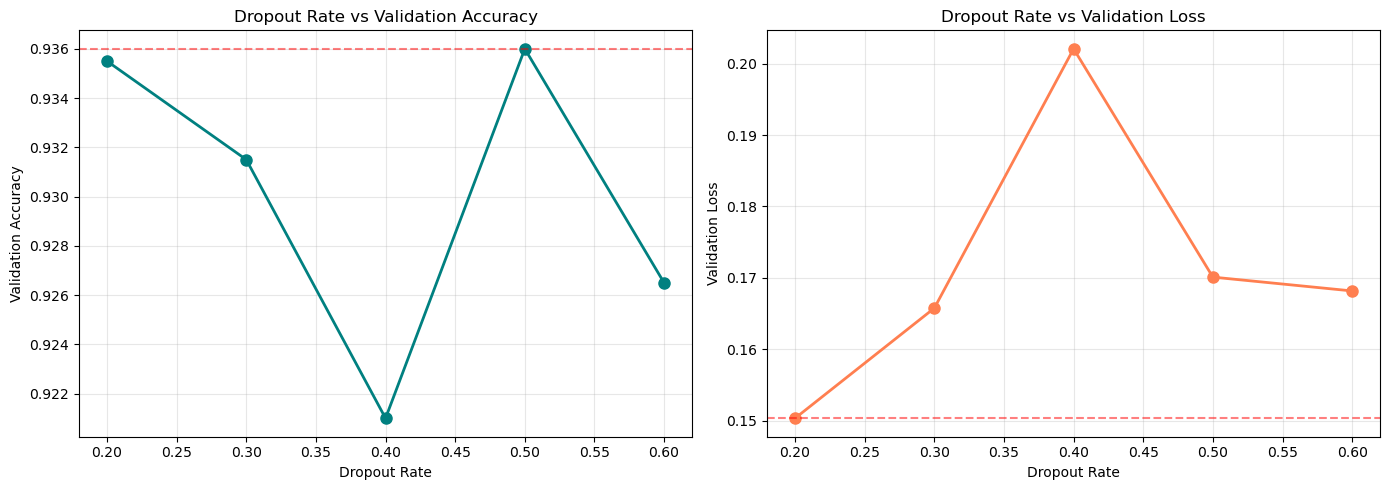


✅ Best Dropout Rate: 0.5 with accuracy 0.9360


In [19]:
# Test different dropout rates
dropout_rates = [0.2, 0.3, 0.4, 0.5, 0.6]
dropout_results = []

print("Testing different dropout rates...")
print("=" * 60)

for dr in dropout_rates:
    print(f"Testing dropout rate: {dr}")
    result = train_gru_model(dropout_rate=dr, epochs=10)
    dropout_results.append({
        'dropout_rate': dr,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss'],
        'epochs': result['best_epoch']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}, Val Loss: {result['val_loss']:.4f}\n")

# Convert to DataFrame
dropout_df = pd.DataFrame(dropout_results)
print("\n📊 Dropout Rate Results:")
print(dropout_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(dropout_df['dropout_rate'], dropout_df['val_accuracy'], 'o-', linewidth=2, markersize=8, color='teal')
axes[0].set_xlabel('Dropout Rate')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Dropout Rate vs Validation Accuracy')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=dropout_df['val_accuracy'].max(), color='r', linestyle='--', alpha=0.5)

axes[1].plot(dropout_df['dropout_rate'], dropout_df['val_loss'], 'o-', linewidth=2, markersize=8, color='coral')
axes[1].set_xlabel('Dropout Rate')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Dropout Rate vs Validation Loss')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=dropout_df['val_loss'].min(), color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

best_dropout = dropout_df.loc[dropout_df['val_accuracy'].idxmax(), 'dropout_rate']
print(f"\n✅ Best Dropout Rate: {best_dropout} with accuracy {dropout_df['val_accuracy'].max():.4f}")


### 🔍 Experiment 5: Optimizer Comparison

Test different optimizers to find the best one.


In [ ]:
# Test different optimizers
optimizers = ['adam', 'rmsprop', 'sgd']
opt_results = []

print("Testing different optimizers...")
print("=" * 60)

for opt in optimizers:
    print(f"Testing optimizer: {opt}")
    result = train_gru_model(optimizer_name=opt, epochs=10)
    opt_results.append({
        'optimizer': opt,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss'],
        'epochs': result['best_epoch']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}, Val Loss: {result['val_loss']:.4f}\n")

# Convert to DataFrame
opt_df = pd.DataFrame(opt_results)
print("\n📊 Optimizer Results:")
print(opt_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(opt_df['optimizer'], opt_df['val_accuracy'], color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black', linewidth=2)
axes[0].set_xlabel('Optimizer')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Optimizer vs Validation Accuracy')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axhline(y=opt_df['val_accuracy'].max(), color='orange', linestyle='--', alpha=0.5, label='Best')
axes[0].legend()

axes[1].bar(opt_df['optimizer'], opt_df['val_loss'], color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black', linewidth=2)
axes[1].set_xlabel('Optimizer')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Optimizer vs Validation Loss')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axhline(y=opt_df['val_loss'].min(), color='orange', linestyle='--', alpha=0.5, label='Best')
axes[1].legend()

plt.tight_layout()
plt.show()

best_opt = opt_df.loc[opt_df['val_accuracy'].idxmax(), 'optimizer']
print(f"\n✅ Best Optimizer: {best_opt} with accuracy {opt_df['val_accuracy'].max():.4f}")


### 🔍 Experiment 6: Embedding Trainability

Compare frozen vs fine-tuned Word2Vec embeddings.


In [ ]:
# Test embedding trainability
emb_configs = [False, True]
emb_labels = ['Frozen', 'Fine-tuned']
emb_results = []

print("Testing embedding trainability...")
print("=" * 60)

for trainable, label in zip(emb_configs, emb_labels):
    print(f"Testing: {label} embeddings")
    result = train_gru_model(embedding_trainable=trainable, epochs=10)
    emb_results.append({
        'configuration': label,
        'trainable': trainable,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss'],
        'epochs': result['best_epoch']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}, Val Loss: {result['val_loss']:.4f}\n")

# Convert to DataFrame
emb_df = pd.DataFrame(emb_results)
print("\n📊 Embedding Trainability Results:")
print(emb_df[['configuration', 'val_accuracy', 'val_loss', 'epochs']].to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(emb_df['configuration'], emb_df['val_accuracy'], color=['#9b59b6', '#1abc9c'], edgecolor='black', linewidth=2)
axes[0].set_xlabel('Embedding Configuration')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Embedding Trainability vs Validation Accuracy')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(emb_df['configuration'], emb_df['val_loss'], color=['#9b59b6', '#1abc9c'], edgecolor='black', linewidth=2)
axes[1].set_xlabel('Embedding Configuration')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Embedding Trainability vs Validation Loss')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

best_emb = emb_df.loc[emb_df['val_accuracy'].idxmax(), 'configuration']
print(f"\n✅ Best Configuration: {best_emb} embeddings with accuracy {emb_df['val_accuracy'].max():.4f}")


### 📊 Comprehensive Hyperparameter Tuning Summary

Let's compare all the best configurations from each experiment.


In [ ]:
# Create comprehensive summary
summary_data = []

# Learning Rate
best_lr_row = lr_df.loc[lr_df['val_accuracy'].idxmax()]
summary_data.append({
    'Hyperparameter': 'Learning Rate',
    'Best Value': f"{best_lr_row['learning_rate']}",
    'Val Accuracy': best_lr_row['val_accuracy'],
    'Val Loss': best_lr_row['val_loss']
})

# Batch Size
best_batch_row = batch_df.loc[batch_df['val_accuracy'].idxmax()]
summary_data.append({
    'Hyperparameter': 'Batch Size',
    'Best Value': f"{int(best_batch_row['batch_size'])}",
    'Val Accuracy': best_batch_row['val_accuracy'],
    'Val Loss': best_batch_row['val_loss']
})

# GRU Units
best_gru_row = gru_df.loc[gru_df['val_accuracy'].idxmax()]
summary_data.append({
    'Hyperparameter': 'GRU Units',
    'Best Value': f"{int(best_gru_row['gru_units'])}",
    'Val Accuracy': best_gru_row['val_accuracy'],
    'Val Loss': best_gru_row['val_loss']
})

# Dropout Rate
best_dropout_row = dropout_df.loc[dropout_df['val_accuracy'].idxmax()]
summary_data.append({
    'Hyperparameter': 'Dropout Rate',
    'Best Value': f"{best_dropout_row['dropout_rate']}",
    'Val Accuracy': best_dropout_row['val_accuracy'],
    'Val Loss': best_dropout_row['val_loss']
})

# Optimizer
best_opt_row = opt_df.loc[opt_df['val_accuracy'].idxmax()]
summary_data.append({
    'Hyperparameter': 'Optimizer',
    'Best Value': best_opt_row['optimizer'],
    'Val Accuracy': best_opt_row['val_accuracy'],
    'Val Loss': best_opt_row['val_loss']
})

# Embedding Trainability
best_emb_row = emb_df.loc[emb_df['val_accuracy'].idxmax()]
summary_data.append({
    'Hyperparameter': 'Embedding Mode',
    'Best Value': best_emb_row['configuration'],
    'Val Accuracy': best_emb_row['val_accuracy'],
    'Val Loss': best_emb_row['val_loss']
})

summary_df = pd.DataFrame(summary_data)

print("\n" + "=" * 80)
print("🏆 HYPERPARAMETER TUNING RESULTS SUMMARY")
print("=" * 80)
print(summary_df.to_string(index=False))
print("=" * 80)

# Visualize all best configurations
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Best Accuracy for each hyperparameter
ax1 = fig.add_subplot(gs[0, :])
colors = plt.cm.viridis(np.linspace(0, 1, len(summary_df)))
bars = ax1.barh(summary_df['Hyperparameter'], summary_df['Val Accuracy'], color=colors, edgecolor='black', linewidth=2)
ax1.set_xlabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Best Validation Accuracy for Each Hyperparameter', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
for i, (bar, val, best_val) in enumerate(zip(bars, summary_df['Val Accuracy'], summary_df['Best Value'])):
    ax1.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{val:.4f} ({best_val})', va='center', fontweight='bold')

# Plot 2-7: Individual experiment results
experiments = [
    (lr_df, 'learning_rate', 'Learning Rate', 'log'),
    (batch_df, 'batch_size', 'Batch Size', 'linear'),
    (gru_df, 'gru_units', 'GRU Units', 'linear'),
    (dropout_df, 'dropout_rate', 'Dropout Rate', 'linear'),
]

for idx, (df, x_col, title, scale) in enumerate(experiments):
    ax = fig.add_subplot(gs[1 + idx // 2, idx % 2])
    ax.plot(df[x_col], df['val_accuracy'], 'o-', linewidth=2, markersize=8, label='Val Accuracy')
    ax.set_xlabel(title)
    ax.set_ylabel('Validation Accuracy')
    ax.set_title(f'{title} Impact')
    if scale == 'log':
        ax.set_xscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend()
    # Highlight best
    best_idx = df['val_accuracy'].idxmax()
    ax.scatter(df.loc[best_idx, x_col], df.loc[best_idx, 'val_accuracy'], 
               color='red', s=200, marker='*', zorder=5, label='Best')

plt.suptitle('GRU Model - Hyperparameter Tuning Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.show()

# Print recommendations
print("\n" + "=" * 80)
print("💡 RECOMMENDATIONS FOR OPTIMAL GRU MODEL")
print("=" * 80)
print(f"Learning Rate:       {summary_df.loc[0, 'Best Value']}")
print(f"Batch Size:          {summary_df.loc[1, 'Best Value']}")
print(f"GRU Units:           {summary_df.loc[2, 'Best Value']}")
print(f"Dropout Rate:        {summary_df.loc[3, 'Best Value']}")
print(f"Optimizer:           {summary_df.loc[4, 'Best Value']}")
print(f"Embedding Mode:      {summary_df.loc[5, 'Best Value']}")
print("=" * 80)
print(f"\n🎯 Expected Validation Accuracy: {summary_df['Val Accuracy'].max():.4f}")
print(f"📉 Expected Validation Loss:     {summary_df['Val Loss'].min():.4f}")


## 💾 Save Model and Tokenizer

Save the trained model and tokenizer for later use.


In [ ]:
# Save the model
model.save('./data/gru/gru_model.keras')
print("✅ Model saved to: ./data/gru/gru_model.keras")

# Save the tokenizer
with open('./data/gru/gru_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer saved to: ./data/gru/gru_tokenizer.pkl")

# Save training metadata
metadata = {
    'maxlen': maxlen,
    'input_size': input_size,
    'val_accuracy': val_accuracy,
    'val_loss': val_loss,
    'best_epoch': best_epoch
}

with open('./data/gru/gru_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print("✅ Metadata saved to: ./data/gru/gru_metadata.pkl")

print(f"\n{'='*60}")
print("GRU MODEL TRAINING COMPLETE!")
print(f"{'='*60}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")


✅ Model saved to: ./data/gru_model.keras
✅ Tokenizer saved to: ./data/gru_tokenizer.pkl
✅ Metadata saved to: ./data/gru_metadata.pkl

GRU MODEL TRAINING COMPLETE!
Final Validation Accuracy: 0.9025
Final Validation Loss: 0.3354
